In [110]:
##########################################################################
# author: patricewangen
# created: 27 February 2020
# last_edited: 3 March 2020
##########################################################################

# TODO
# (1) Pre-Processing [continued]
#     - np.nan, None, "" handling in pandas
#     - Pre-Processing: Punctuation, Numbers, Stopwords, Stemming, URL
#     - DTM functionalities: n-grams, custom tokenizer, max_features
# (2) Cosine Similarity
# (3) Homework Solutions

import os
import pandas as pd
import numpy as np
import feather

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import SnowballStemmer

import string

In [111]:
# (1) Recap [finishing 04_NLP-1.ipynb]
# We'll continue to use the tweets from last week.
df = feather.read_dataframe("DATA/love-triangle.feather")

# Let's start with clearing up the missing value issue some of you encountered when
# opening the love-triangle.feather file. If I understood correctly, depending on
# your operating system, an empty cell gets either converted into a None object,
# a numpy np.nan, or an empty string ("") – the latter created some problems when
# trying to change things down the line. In my case, my computer gives me None objects
# which pandas recognizes as missing value:
df.loc[0:10, 'tweet_text'].isna() # or .isnull(), which is functionally similar

0      True
1     False
2      True
3      True
4     False
5     False
6     False
7      True
8     False
9      True
10    False
Name: tweet_text, dtype: bool

In [112]:
# If we replace these missing values with empty strings, I think I was able to
# recreate the issue some people faced:
df.replace(np.nan, "", inplace=True)
df

,ID,json_file,json_pos,processed_at,user_id,user_handle,user_loc,user_desc,tweet_text,tweet_id,...,qu_user_desc,qu_tweet_text,qu_tweet_id,qu_tweet_time,qu_tweet_geo,qu_tweet_country,qu_tweet_loc,qu_tweet_loc_type,qu_tweet_hashtags,qu_tweet_mentions
0,1259863,2019-05-06_12-11-56,8979,2019-09-19 11:47:00,3131144855,BorisJohnson,London,MP for Uxbridge and South Ruislip,,1125328351974105088,...,,,0,1900-01-01 00:00:00,False,,,,,
1,3794418,2019-09-05_21-10-31,1624,2019-09-19 14:07:00,3131144855,BorisJohnson,United Kingdom,Prime Minister of the United Kingdom and @Cons...,Corbyn and his friends in Parliament don’t tru...,1169681044573962240,...,,,0,1900-01-01 00:00:00,False,,,,,
2,3895193,2019-06-19_18-33-12,8378,2019-09-19 14:13:00,3131144855,BorisJohnson,United Kingdom,MP for Uxbridge and South Ruislip #BackBoris,,1141362273941958666,...,,,0,1900-01-01 00:00:00,False,,,,,
3,5512364,2019-08-19_09-25-10,17164,2019-09-19 15:44:00,3131144855,BorisJohnson,United Kingdom,Prime Minister of the United Kingdom and @Cons...,,1163346035718205440,...,,,0,1900-01-01 00:00:00,False,,,,,
4,5908998,2019-06-15_17-58-59,24268,2019-09-19 16:06:00,3131144855,BorisJohnson,United Kingdom,MP for Uxbridge and South Ruislip #BackBoris,Fantastic to address our party faithful at the...,1139923957296111617,...,,,0,1900-01-01 00:00:00,False,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,70388493,2019-08-27_19-22-41,9680,2019-09-23 00:43:00,3131144855,BorisJohnson,United Kingdom,Prime Minister of the United Kingdom and @Cons...,Jeremy Corbyn wants to cancel the referendum a...,1166391520062300160,...,,,0,1900-01-01 00:00:00,False,,,,,
153,70751519,2019-08-29_13-36-31,7660,2019-09-23 01:13:00,3131144855,BorisJohnson,United Kingdom,Prime Minister of the United Kingdom and @Cons...,,1167030319775735811,...,,,0,1900-01-01 00:00:00,False,,,,,
154,71742418,2019-09-09_14-02-14,6016,2019-09-23 02:27:00,3131144855,BorisJohnson,United Kingdom,Prime Minister of the United Kingdom and @Cons...,Let’s come together and get Brexit done on Oct...,1171024527410814976,...,,,0,1900-01-01 00:00:00,False,,,,,
155,72721638,2019-06-28_18-02-17,17833,2019-09-23 03:40:00,3131144855,BorisJohnson,United Kingdom,MP for Uxbridge and South Ruislip #BackBoris,Thank you @JSHeappey for the invitation to spe...,1144626979045629952,...,,,0,1900-01-01 00:00:00,False,,,,,


In [113]:
# Now let's see whether pandas recognizes the missing value in this case.
df.loc[1:10, 'tweet_text'].isna()

1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
Name: tweet_text, dtype: bool

In [114]:
# In order to get back to a manageable version of missing values,
# we can simply use the same function to replace empty string values ("")
# with np.nan – as mentioned in class, I think the np.nan approach is the
# most consistent one. But most important is that you keep a certain level
# of consistency in your code and data. Be particularly careful with this 
# if you are merging two different pandas DataFrames.
df.replace("", np.nan, inplace=True)
df

,ID,json_file,json_pos,processed_at,user_id,user_handle,user_loc,user_desc,tweet_text,tweet_id,...,qu_user_desc,qu_tweet_text,qu_tweet_id,qu_tweet_time,qu_tweet_geo,qu_tweet_country,qu_tweet_loc,qu_tweet_loc_type,qu_tweet_hashtags,qu_tweet_mentions
0,1259863,2019-05-06_12-11-56,8979,2019-09-19 11:47:00,3131144855,BorisJohnson,London,MP for Uxbridge and South Ruislip,NaN,1125328351974105088,...,NaN,NaN,0,1900-01-01 00:00:00,False,NaN,NaN,NaN,NaN,NaN
1,3794418,2019-09-05_21-10-31,1624,2019-09-19 14:07:00,3131144855,BorisJohnson,United Kingdom,Prime Minister of the United Kingdom and @Cons...,Corbyn and his friends in Parliament don’t tru...,1169681044573962240,...,NaN,NaN,0,1900-01-01 00:00:00,False,NaN,NaN,NaN,NaN,NaN
2,3895193,2019-06-19_18-33-12,8378,2019-09-19 14:13:00,3131144855,BorisJohnson,United Kingdom,MP for Uxbridge and South Ruislip #BackBoris,NaN,1141362273941958666,...,NaN,NaN,0,1900-01-01 00:00:00,False,NaN,NaN,NaN,NaN,NaN
3,5512364,2019-08-19_09-25-10,17164,2019-09-19 15:44:00,3131144855,BorisJohnson,United Kingdom,Prime Minister of the United Kingdom and @Cons...,NaN,1163346035718205440,...,NaN,NaN,0,1900-01-01 00:00:00,False,NaN,NaN,NaN,NaN,NaN
4,5908998,2019-06-15_17-58-59,24268,2019-09-19 16:06:00,3131144855,BorisJohnson,United Kingdom,MP for Uxbridge and South Ruislip #BackBoris,Fantastic to address our party faithful at the...,1139923957296111617,...,NaN,NaN,0,1900-01-01 00:00:00,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,70388493,2019-08-27_19-22-41,9680,2019-09-23 00:43:00,3131144855,BorisJohnson,United Kingdom,Prime Minister of the United Kingdom and @Cons...,Jeremy Corbyn wants to cancel the referendum a...,1166391520062300160,...,NaN,NaN,0,1900-01-01 00:00:00,False,NaN,NaN,NaN,NaN,NaN
153,70751519,2019-08-29_13-36-31,7660,2019-09-23 01:13:00,3131144855,BorisJohnson,United Kingdom,Prime Minister of the United Kingdom and @Cons...,NaN,1167030319775735811,...,NaN,NaN,0,1900-01-01 00:00:00,False,NaN,NaN,NaN,NaN,NaN
154,71742418,2019-09-09_14-02-14,6016,2019-09-23 02:27:00,3131144855,BorisJohnson,United Kingdom,Prime Minister of the United Kingdom and @Cons...,Let’s come together and get Brexit done on Oct...,1171024527410814976,...,NaN,NaN,0,1900-01-01 00:00:00,False,NaN,NaN,NaN,NaN,NaN
155,72721638,2019-06-28_18-02-17,17833,2019-09-23 03:40:00,3131144855,BorisJohnson,United Kingdom,MP for Uxbridge and South Ruislip #BackBoris,Thank you @JSHeappey for the invitation to spe...,1144626979045629952,...,NaN,NaN,0,1900-01-01 00:00:00,False,NaN,NaN,NaN,NaN,NaN


In [115]:
# ~~~ PRE-PROCESSING ~~~
# Let's focus again on the non-missing tweet texts by Boris, Theresa, and Donald.
df = df.loc[df['tweet_text'].notnull(), ['user_handle', 'tweet_text']]

# Reset the index to avoid confusion down the line
df = df.reset_index(drop=True)

# And take the first tweet text to introduce and explore all of our 
# pre-processing steps before applying it to the entire column.
tweet = df.loc[0,'tweet_text']
tweet

'Corbyn and his friends in Parliament don’t trust you to make this decision - but I do. Let’s put it to the people: more delay with Corbyn’s #SurrenderBill, or Brexit delivered on October 31st ???? https://t.co/q8tIwDMkcH'

In [116]:
# Let's do the first two steps we covered last week: tokenizing
# and lowercasing. We imported the TweetTokenizer at the outset
# of this script, so we just need to initialize an instance of
# this calss into a calleable python object

# Tokenize the tweet
tok = TweetTokenizer()
tokens = tok.tokenize(tweet)

# Convert every token to its lowercase version
tokens = [t.lower() for t in tokens]
tokens

['corbyn',
 'and',
 'his',
 'friends',
 'in',
 'parliament',
 'don',
 '’',
 't',
 'trust',
 'you',
 'to',
 'make',
 'this',
 'decision',
 '-',
 'but',
 'i',
 'do',
 '.',
 'let',
 '’',
 's',
 'put',
 'it',
 'to',
 'the',
 'people',
 ':',
 'more',
 'delay',
 'with',
 'corbyn',
 '’',
 's',
 '#surrenderbill',
 ',',
 'or',
 'brexit',
 'delivered',
 'on',
 'october',
 '31st',
 '?',
 '?',
 '?',
 'https://t.co/q8tiwdmkch']

In [117]:
# [3c] Punctuation Removal
# There are a bunch of approaches to this, but let's
# use the string package, which has a lot of other
# cool features
import string

In [118]:
# It contains a list of the most common punctuation 
# characters
punct = string.punctuation
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [119]:
# Problem is that this list contains the # and @ symbol,
# which we do want to keep, so let's replace this
punct = punct.replace("#", "")
punct = punct.replace("@", "")
punct

'!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~'

In [120]:
# Now, we can use list comprehension to drop all
# the punctuation tokens in our list of tokens
tokens = [word for word in tokens if word not in punct]
tokens

['corbyn',
 'and',
 'his',
 'friends',
 'in',
 'parliament',
 'don',
 '’',
 't',
 'trust',
 'you',
 'to',
 'make',
 'this',
 'decision',
 'but',
 'i',
 'do',
 'let',
 '’',
 's',
 'put',
 'it',
 'to',
 'the',
 'people',
 'more',
 'delay',
 'with',
 'corbyn',
 '’',
 's',
 '#surrenderbill',
 'or',
 'brexit',
 'delivered',
 'on',
 'october',
 '31st',
 'https://t.co/q8tiwdmkch']

In [121]:
# As we see, this didn't remove the ’ – let's just add it to punct,
# and repeat the process
punct = punct + "’"
punct

'!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~’'

In [122]:
# Now we are left with only alphanumerical characters
# and we managed to not throw away the hashtag sign.
# in the process.
tokens = [word for word in tokens if word not in punct]
tokens

['corbyn',
 'and',
 'his',
 'friends',
 'in',
 'parliament',
 'don',
 't',
 'trust',
 'you',
 'to',
 'make',
 'this',
 'decision',
 'but',
 'i',
 'do',
 'let',
 's',
 'put',
 'it',
 'to',
 'the',
 'people',
 'more',
 'delay',
 'with',
 'corbyn',
 's',
 '#surrenderbill',
 'or',
 'brexit',
 'delivered',
 'on',
 'october',
 '31st',
 'https://t.co/q8tiwdmkch']

In [123]:
# [3d] Number Removal
# If we just want to remove pure numbers, the task is easy. 
tokens = [w for w in tokens if not w.isdigit()]
tokens

['corbyn',
 'and',
 'his',
 'friends',
 'in',
 'parliament',
 'don',
 't',
 'trust',
 'you',
 'to',
 'make',
 'this',
 'decision',
 'but',
 'i',
 'do',
 'let',
 's',
 'put',
 'it',
 'to',
 'the',
 'people',
 'more',
 'delay',
 'with',
 'corbyn',
 's',
 '#surrenderbill',
 'or',
 'brexit',
 'delivered',
 'on',
 'october',
 '31st',
 'https://t.co/q8tiwdmkch']

In [124]:
# In this case, it does not do anything because there are no
# strings that only consists of digits. But we do have "31st"
# which we might want to remove (remember, this is similar to 
# "Article50" and might therefore be useful to keep). But let's
# try to get rid of it nevertheless.
"31st".isdigit()

False

In [125]:
# In this case, we could specify for example a for loop that 
# checks whether any of the characters in a given string is
# a digit.
any(char.isdigit() for char in "31st")

# We could insert that into list comprehension, but let's 
# leave it to keep stuff like #RevokeArticle50, which
# might be important in the context of Brexit

True

In [126]:
# [3e] Stopword Removal
# There are many different stopwords lists that contain
# words conventionally thought of as carrying little 
# meaning. You should always inspect the stopwords lists
# you use to ensure that it does not accidently delete
# things that matter in your context. Let's look at the 
# NLTK standard stoplist for English.
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [127]:
# This looks fine to me, so let's get rid of all of these
# words in our list of tokens. 
tokens = [w for w in tokens if not w in stop_words]
tokens

['corbyn',
 'friends',
 'parliament',
 'trust',
 'make',
 'decision',
 'let',
 'put',
 'people',
 'delay',
 'corbyn',
 '#surrenderbill',
 'brexit',
 'delivered',
 'october',
 '31st',
 'https://t.co/q8tiwdmkch']

In [128]:
# [3f] Stemming
# Finally, let's stem the leftovers and thereby
# get rid of all the suffixes and stuff. The 
# Porter Stemmer is one of the most widely used.
from nltk.stem import PorterStemmer
porter = PorterStemmer()

tokens_porter = [porter.stem(w) for w in tokens]
tokens_porter

['corbyn',
 'friend',
 'parliament',
 'trust',
 'make',
 'decis',
 'let',
 'put',
 'peopl',
 'delay',
 'corbyn',
 '#surrenderbil',
 'brexit',
 'deliv',
 'octob',
 '31st',
 'https://t.co/q8tiwdmkch']

In [129]:
# Another widespread one is the SnowballStemmer,
# which is also available in some different languages,
# which might come in handy if you want to keep
# pre-processing fairly similar across different
# languages in your texts.
from nltk import SnowballStemmer
stemmer = SnowballStemmer("english")

tokens_snowball = [stemmer.stem(w) for w in tokens]
tokens_snowball

['corbyn',
 'friend',
 'parliament',
 'trust',
 'make',
 'decis',
 'let',
 'put',
 'peopl',
 'delay',
 'corbyn',
 '#surrenderbil',
 'brexit',
 'deliv',
 'octob',
 '31st',
 'https://t.co/q8tiwdmkch']

In [130]:
# [3g] URL removal
# We can simply drop everything that contains "https://"
tokens = [word for word in tokens_porter if not "https://" in word]
tokens

['corbyn',
 'friend',
 'parliament',
 'trust',
 'make',
 'decis',
 'let',
 'put',
 'peopl',
 'delay',
 'corbyn',
 '#surrenderbil',
 'brexit',
 'deliv',
 'octob',
 '31st']

In [131]:
# As we can see in this case, the different stemmers return
# the same result. But remember to double-check with different
# tweets and keep in mind that this is one parameter you can 
# change in your analysis. 

# Let's write a loop that applies all of this to each tweet 
# in the dataframe and creates a new 'processed' variable. 
# that we can turn into a DTM now. Let's create a new variable
# to make sure that we don't loose the original text
df['processed'] = df['tweet_text']
df

,user_handle,tweet_text,processed
0,BorisJohnson,Corbyn and his friends in Parliament don’t tru...,Corbyn and his friends in Parliament don’t tru...
1,BorisJohnson,Fantastic to address our party faithful at the...,Fantastic to address our party faithful at the...
2,theresa_may,You want this stage of the Brexit process to b...,You want this stage of the Brexit process to b...
3,eucopresident,EU27 unanimously agrees on its response to UK’...,EU27 unanimously agrees on its response to UK’...
4,BorisJohnson,I’m deeply honoured to have secured more than ...,I’m deeply honoured to have secured more than ...
...,...,...,...
91,BorisJohnson,I’m standing to be Leader of the Conservative ...,I’m standing to be Leader of the Conservative ...
92,BorisJohnson,Jeremy Corbyn wants to cancel the referendum a...,Jeremy Corbyn wants to cancel the referendum a...
93,BorisJohnson,Let’s come together and get Brexit done on Oct...,Let’s come together and get Brexit done on Oct...
94,BorisJohnson,Thank you @JSHeappey for the invitation to spe...,Thank you @JSHeappey for the invitation to spe...


In [132]:
# Now let's pre-process all of these tweets in order to 
# make our DTM conceptually more valid.
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

import string
punct = string.punctuation
punct = punct.replace("@", "")
punct = punct.replace("#", "")
punct = punct + "’"

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

for ix in range(0, len(df)):
    tweet = df.loc[ix, "tweet_text"]
    
    # TweetTokenizer
    tokens = tokenizer.tokenize(tweet)
    
    # Lowercasing
    tokens = [word.lower() for word in tokens]
    
    # Punctuation Removal
    tokens = [word for word in tokens if word not in punct]
    
    # Number removal
    tokens = [word for word in tokens if not word.isdigit()]
    
    # Stopword removal
    tokens = [word for word in tokens if not word in stop_words]
    
    # Stemming (Porter)
    tokens = [porter.stem(w) for w in tokens]
    
    # URL removal
    tokens = [word for word in tokens if not "https://" in word]
    
    # In order to put this back into a single cell that can
    # be put into the CountVectorizer, we can use the .join()
    # method to put all individual strings back together, 
    # separated by whitespace.
    tweet = " ".join(tokens)
    
    # now save it into the "processed" column
    df.loc[ix, "processed"] = tweet

# Let's look at the outcome...
df

,user_handle,tweet_text,processed
0,BorisJohnson,Corbyn and his friends in Parliament don’t tru...,corbyn friend parliament trust make decis let ...
1,BorisJohnson,Fantastic to address our party faithful at the...,fantast address parti faith nation conserv con...
2,theresa_may,You want this stage of the Brexit process to b...,want stage brexit process done agre side
3,eucopresident,EU27 unanimously agrees on its response to UK’...,eu27 unanim agre respons uk request meet pm @t...
4,BorisJohnson,I’m deeply honoured to have secured more than ...,deepli honour secur per cent vote final ballot...
...,...,...,...
91,BorisJohnson,I’m standing to be Leader of the Conservative ...,stand leader conserv parti deliv proper brexit...
92,BorisJohnson,Jeremy Corbyn wants to cancel the referendum a...,jeremi corbyn want cancel referendum argu brex...
93,BorisJohnson,Let’s come together and get Brexit done on Oct...,let come togeth get brexit done octob 31st
94,BorisJohnson,Thank you @JSHeappey for the invitation to spe...,thank @jsheappey invit speak fantast member we...


In [133]:
# ~~~ Pre-Processing steps that you do with the Vectorizer
# [A] If you want to use n-grams of any size, you would tell your
# vectorizer to consider a range of word-combination possibilities
# when constructing the vocabulary (the columns) of the DTM. If
# you want to include bi-grams in addition to single tokens, you
# would use the following argument:
vectorizer = CountVectorizer(ngram_range=(0,2))
dtm = vectorizer.fit_transform(df['processed'])
dtm

# Notice that this exponentially increases the number of columns in 
# DTM.

<96x1602 sparse matrix of type '<class 'numpy.int64'>'
	with 3188 stored elements in Compressed Sparse Row format>

In [134]:
# [B] Depending on your research question, the limits of your 
# computational resources, or just out of curiosity, you might
# want to remove infrequently used terms from your DTM. You can
# tell the Vectorizer to only use the top-n features in your
# documents. If you want to inspect what this does, you can 
# look at the stop_words_ of your vectorizer to get a list
# of the automatically removed tokens.
vectorizer = CountVectorizer(max_features=200)
dtm = vectorizer.fit_transform(df['processed'])
dtm

<96x200 sparse matrix of type '<class 'numpy.int64'>'
	with 1213 stored elements in Compressed Sparse Row format>

In [135]:
# Note that in this case "stopwords" is differently conceptualized.
# Previously, we used a pre-defined list of words that other researchers
# have found to be unimportant for computational processing of natural 
# languages. In this case, the vectorizer empirically drops those words
# that are least frequently used in your documents. This approach would
# probably NOT drop words like "is" or "and" because they tend to be used
# often. Let's have a look at the words this removes:
vectorizer.stop_words_

{'accept',
 'address',
 'afternoon',
 'agenda',
 'also',
 'altern',
 'although',
 'altogeth',
 'alway',
 'amaz',
 'andrejplenkov',
 'anoth',
 'anti',
 'anyon',
 'appeal',
 'approach',
 'around',
 'aspect',
 'avoid',
 'bad',
 'belfast',
 'bench',
 'best',
 'bicest',
 'bill',
 'bold',
 'borisjohnson',
 'bournemouth',
 'break',
 'bring',
 'brussel',
 'buck',
 'but',
 'cabinet',
 'campaignforleo',
 'capitul',
 'cent',
 'champion',
 'chanc',
 'chancellor',
 'check',
 'clear',
 'coldfield',
 'colleagu',
 'commiser',
 'common',
 'concret',
 'condon',
 'confid',
 'confirm',
 'congratul',
 'consensu',
 'conservat',
 'constant',
 'contest',
 'continu',
 'contribut',
 'control',
 'convent',
 'could',
 'councillor',
 'count',
 'creat',
 'creator',
 'crime',
 'date',
 'decid',
 'decis',
 'deepen',
 'deepli',
 'defect',
 'democraci',
 'despair',
 'determin',
 'develop',
 'diet',
 'difficult',
 'dignifi',
 'disappoint',
 'discov',
 'divid',
 'document',
 'dream',
 'dreamer',
 'dublin',
 'either',
 'e

In [136]:
# [C] You might have noticed that our processed tweets are stored
# in single string objects again. To convert these into a DTM, the
# vectorizer again needs to use a tokenizer. Have a look a the 
# documentation and try to understand what the default option does:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# This is also a good moment to have a look at some of the default
# things that CountVectorizer will do for you...

# lowercase: boolean, True by default
# Convert all characters to lowercase before tokenizing.

# token_pattern: callable or None (default)
# Regular expression denoting what constitutes a “token”, 
# only used if analyzer == 'word'. The default regexp select tokens of 2 
# or more alphanumeric characters (punctuation is completely ignored and 
# always treated as a token separator).

# Basically, this means that CountVectorizer automatically converts
# everything into lowercase, removes punctuation, and applies super basic
# tokenizing. We can override this default processing by defining our
# own tokenizer and/or preprocessor function.

# This is nice, but this introduces a problem because it also removes 
# hashtags and @ signs from our tokens. Luckily, we can overwrite all
# of these default functionalities.

# Since we know that our processed strings are tokens simply separated
# by whitespace, we can use the split method to get there. But in order
# to incorporate this into the vectorizer, we need to write this out as
# function rather than a method. 
def split_tok(string):
    return(string.split())

vectorizer = CountVectorizer(tokenizer=split_tok)
dtm = vectorizer.fit_transform(df['processed'])
vectorizer.get_feature_names()

['#backbori',
 '#brexit',
 '#euco',
 '#itvdeb',
 '#leaveoct31',
 '#letsgetthisdon',
 '#peterborough',
 '#surrenderbil',
 '):',
 '...',
 '31st',
 '@andrejplenkov',
 '@backbori',
 '@borisjohnson',
 '@campaignforleo',
 '@conserv',
 '@emmanuelmacron',
 '@eucopresid',
 '@fitzmp',
 '@gavinwilliamson',
 '@georgefreeman',
 '@georgefreemanmp',
 '@gitanasnauseda',
 '@giuseppeconteit',
 '@grybauskaite_lt',
 '@iainastewart',
 '@jeremy_hunt',
 '@jsheappey',
 '@krisjaniskarin',
 '@minpr',
 '@mkconserv',
 '@paulbristow79',
 '@sarecmarjan',
 '@talkradio',
 '@theresa_may',
 '@thesun',
 'accept',
 'across',
 'address',
 'afternoon',
 'agenda',
 'agre',
 'agreement',
 'ahead',
 'also',
 'altern',
 'although',
 'altogeth',
 'alway',
 'amaz',
 'anoth',
 'anti',
 'anyon',
 'appeal',
 'approach',
 'april',
 'argu',
 'around',
 'art',
 'ask',
 'aspect',
 'avoid',
 'back',
 'backstop',
 'bad',
 'ballot',
 'becom',
 'begin',
 'belfast',
 'believ',
 'bench',
 'best',
 'better',
 'beyond',
 'bicest',
 'big',
 'bi

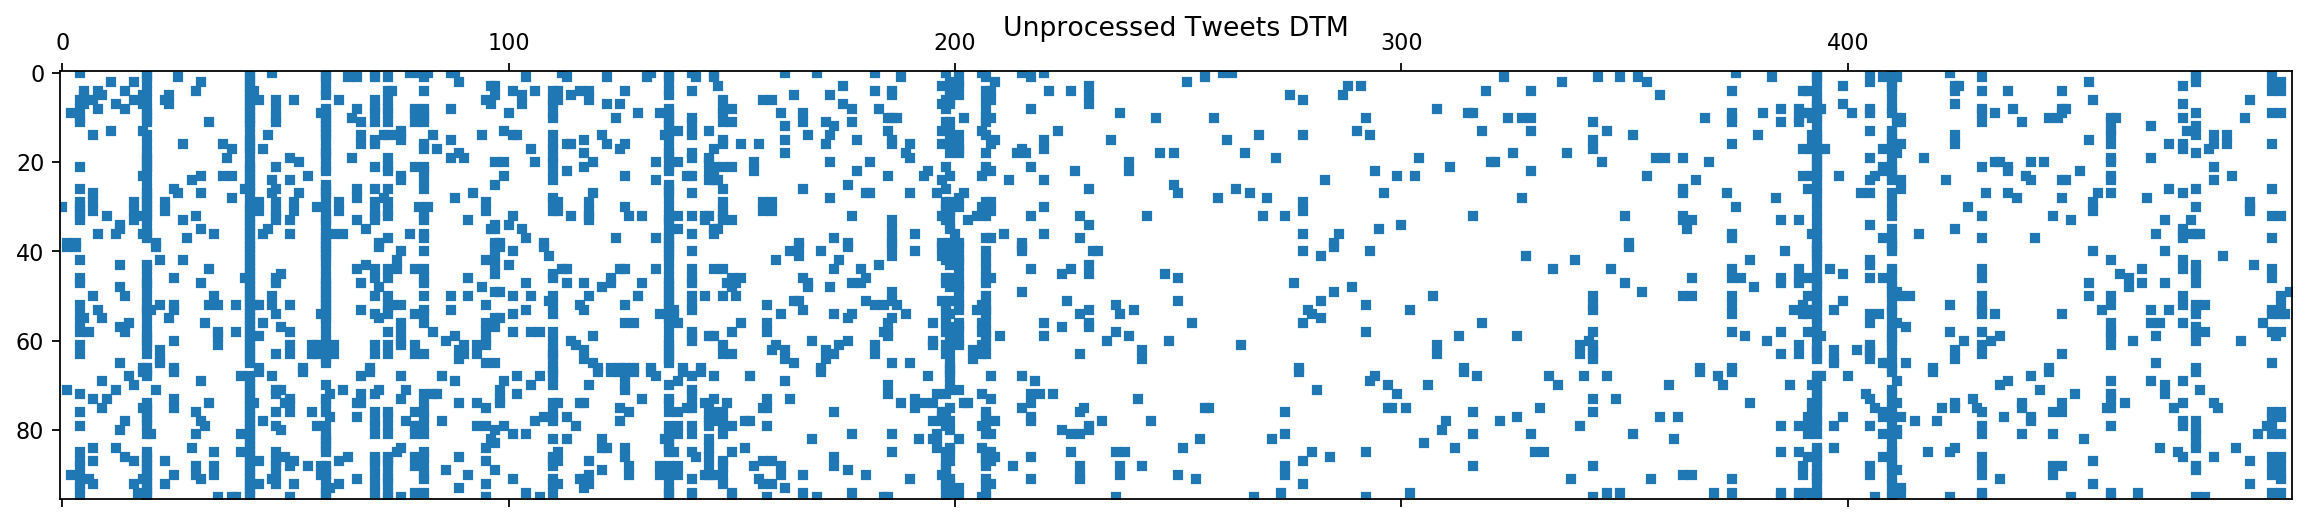

In [137]:
# While your primary tool to explore the impact of your pre-processing
# steps is always the hands-on reading of the features in your DTM, we
# can also visualize this DTM to explore the distribution of your term-counts
# Let's create two different DTMs: one for the unprocessed and one for the
# processed tweets
vectorizer = CountVectorizer(max_features = 500)
dtm_raw = vectorizer.fit_transform(df['tweet_text'])

vectorizer = CountVectorizer(tokenizer=split_tok)
dtm_proc = vectorizer.fit_transform(df['processed'])

# FYI: If you want production level or publication ready graphs, python is 
# not your best friend. Therefore, we won't spend too much time on 
# making these things look pretty. If you want that, the current consensus
# is that the R package ggplot is the way to go. If you need interactive
# graphs, you can use the R package plotly and/or shiny. If you want to
# go full-scale web-development interactive visualization, you would go
# for D3.js 

# That being said, we can still use matplotlib to make basic graphs in
# python that can be helpful in your data analytical process. To make
# matplotlib a bit more userfriendly, you would usually use the seaborn
# package as well.
import seaborn as sns
import matplotlib.pylab as plt

# The following sets some depiction options to ensure that the jupyter
# notebook output is filling the entire space and producing a high-resolution
# image. Play with the values to make it work for your specific computer 
# screen and browser
plt.figure(figsize=(18, 16), dpi= 160, facecolor='w', edgecolor='k')

# To visualize a 2-dimensional matrix, matplotlib has the spy function.
# The markersize specifies the size of the individual cell visualizations.
# Again, play around with it so it works well on your computer.
plt.spy(dtm_raw, markersize=4)
plt.title('Unprocessed Tweets DTM')
plt.show() # not always necessary depending on your package versions

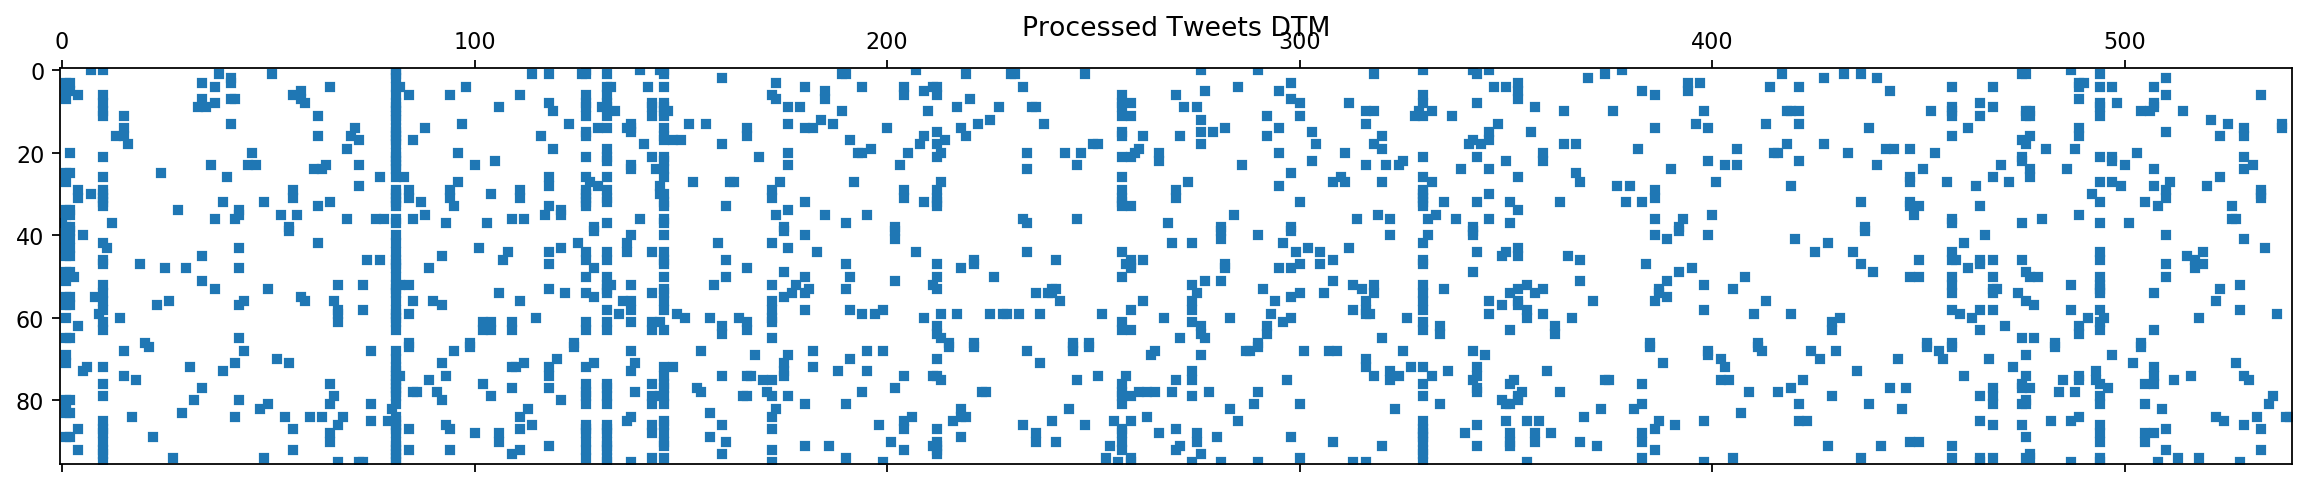

In [138]:
plt.figure(figsize=(18, 16), dpi= 160, facecolor='w', edgecolor='k')
plt.spy(dtm_proc, markersize=4)
plt.title('Processed Tweets DTM')
plt.show()
# The basic take-away is that your processed version got rid of a lot of
# tokens that don't vary that much across tweets, and hopefully focused 
# your DTM on tokens whose variation contains meaningful information for 
# the sake of your research question.

In [139]:
# ~~~~~~~~~~~~~~~~~~~~~ RECAP ~~~~~~~~~~~~~~~~~~~~~
# So far, we covered the following pre-processing steps:
# (1) Tokenizing
# (2) Lowercasing
# (3) Punctuation Removal
# (4) Number Removal
# (5) Stopword Removal
# (6) Stemming
# (7) URL Removal
# (8) N-Grams
# (9) Infrequent Terms Removal

# Of these, only tokenizing is non-optional if we want to use a DTM
# approach to text analysis. But tokenizing can also be done in
# different ways that might affect your analytical outcome. Use 
# conceptual knowledge about your text and research question to
# determine which way to go. Don't use trial-and-error to fish for
# the finding that you like best (this is about your integrety as a
# researcher), but do use trial-and-error to understand what is 
# happening to your data and how this affects your analytical outcome.
# Try to be as transparent and reflective about this as possible. 
# Justify every step you take. – If you can't do that in the written
# text that summarizes your findings, try to document these choices in
# your replication code (i.e., your jupyter notebook)
# ~~~~~~~~~~~~~~~~~~~~~ RECAP ~~~~~~~~~~~~~~~~~~~~~

In [140]:
# All of these pre-processing steps will be necessary considerations 
# when we move to the more data-analytical part of the course. You
# will need to think about whether you need/want to do any of these
# when you do unsupervised or supervised learning approaches. For now,
# let's use a much simpler analytical technique to explore the implications
# of pre-processing: cosine similarity – as mentioned in class, this is 
# a fairly widespread approach to analyse how similar the word
# distributions are in two texts. The values can be anything between
# 0 (not similar at all) to 1 (exactly the same). They are difficult
# to interpret as absolute values, but they are informatitive when
# comparing the similarity of a variety of texts (e.g., Boris vs. 
# Theresa vs. Donald)

# To calculate cosine similarities, we need the DTM of the texts
# we want to compare.
from sklearn.metrics.pairwise import cosine_similarity

# If we look at the df dataframe, we can pick two tweets from
# Boris and Tusk and see how they compare in terms of cosine 
# similarity 
print("Boris said: \n" + df.loc[0,'tweet_text'])
print("Bag-of-Words: \n" + df.loc[0, 'processed'])
print("\nDonald said: \n" + df.loc[20, 'tweet_text'])
print("Bag-of-Words: \n" + df.loc[20, 'processed'])

Boris said: 
Corbyn and his friends in Parliament don’t trust you to make this decision - but I do. Let’s put it to the people: more delay with Corbyn’s #SurrenderBill, or Brexit delivered on October 31st ???? https://t.co/q8tIwDMkcH
Bag-of-Words: 
corbyn friend parliament trust make decis let put peopl delay corbyn #surrenderbil brexit deliv octob 31st

Donald said: 
Even if the hope for final success may seem frail, even illusory, and although Brexit fatigue is increasingly visible and justified, we cannot give up seeking - until the very last moment - a positive solution. #euco
Bag-of-Words: 
even hope final success may seem frail even illusori although brexit fatigu increasingli visibl justifi cannot give seek last moment posit solut #euco


In [141]:
# Let's recreate the DTMs just in case they got lost along
# the way in the jupyter notebook
vectorizer = CountVectorizer()
dtm_raw = vectorizer.fit_transform(df['tweet_text'])

vectorizer = CountVectorizer(tokenizer=split_tok)
dtm_proc = vectorizer.fit_transform(df['processed'])

# The unprocessed DTM says these tweets are a tiny bit similar...
cosine_similarity(dtm_raw[0,], dtm_raw[20,])

array([[0.12659242]])

In [142]:
# The processed DTM thinks they are a bit less similar...
cosine_similarity(dtm_proc[0,], dtm_proc[20,])

array([[0.04714045]])

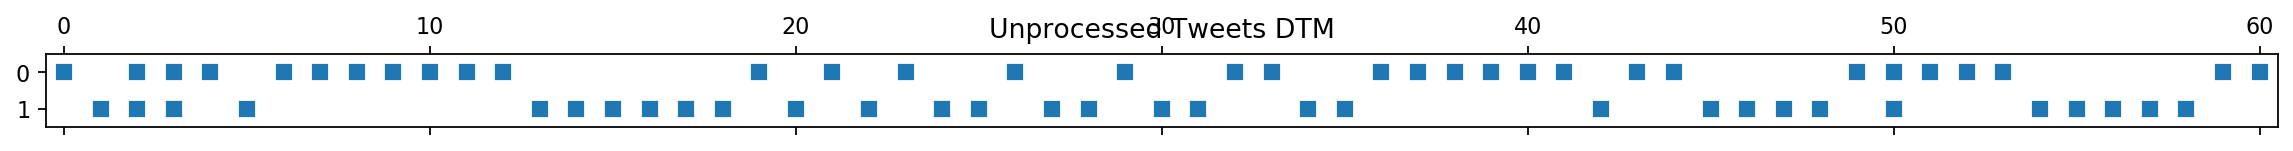

In [143]:
# To understand the logic of cosine_similarity a bit better, let's
# repeat that exercise with only these two tweets fed into the DTM
vectorizer = CountVectorizer()
dtm_raw2 = vectorizer.fit_transform(df.loc[[0,20], 'tweet_text'])

# Let's visualize it and see where tokens are present in both term
# frequency rows
plt.figure(figsize=(18, 16), dpi= 160, facecolor='w', edgecolor='k')
plt.spy(dtm_raw2, markersize=6)
plt.title('Unprocessed Tweets DTM')
plt.show()

In [144]:
# Convert the DTM into a nice pandas dataframe to see which
# tokens are overlapping.
tokens = vectorizer.get_feature_names()
dtm = pd.DataFrame(data=dtm_raw2.toarray(), 
                   columns=tokens)
dtm.iloc[:, [2,3,50]]

,and,brexit,the
0,1,1,1
1,2,1,2


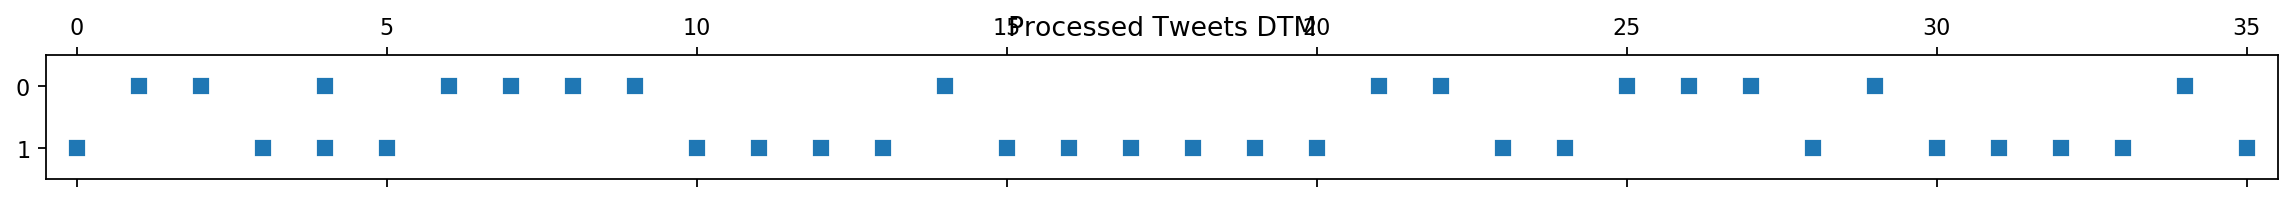

In [145]:
vectorizer = CountVectorizer(tokenizer=split_tok)
dtm_proc2 = vectorizer.fit_transform(df.loc[[0,20], 'processed'])

# Let's visualize it and see where tokens are present in both term
# frequency rows
plt.figure(figsize=(18, 16), dpi= 160, facecolor='w', edgecolor='k')
plt.spy(dtm_proc2, markersize=6)
plt.title('Processed Tweets DTM')
plt.show()

In [146]:
# Convert the DTM into a nice pandas dataframe to see which
# tokens are overlapping.
tokens = vectorizer.get_feature_names()
dtm = pd.DataFrame(data=dtm_proc2.toarray(), 
                   columns=tokens)
dtm.iloc[:, [4]]

,brexit
0,1
1,1


In [147]:
# (2) Homework Solutions
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Exercise 04
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# (1) Unit of analysis challenge: Single tweets lead to zero-inflated
# DTMs, use the join() function to collapse all tweets from each user
# into a single string object. You should end with a list of three
# large strings.
# Tip: Google how to apply join() to a list of strings.

# In order to get all distinct values of a column, we cna simply
# call the unique() method on that column
handles = df['user_handle'].unique()
handles

array(['BorisJohnson', 'theresa_may', 'eucopresident'], dtype=object)

In [148]:
# Create a new empty dataframe to append in a for-loop
df_joint = pd.DataFrame({"user_handle": handles,
                        "tweets": np.nan,
                        "processed": np.nan})
df_joint

,user_handle,tweets,processed
0,BorisJohnson,NaN,NaN
1,theresa_may,NaN,NaN
2,eucopresident,NaN,NaN


In [149]:
# Loop through the rows and collapse all tweets from that person into
# a large string. 
for handle in handles:
    tweets = " ".join(df.loc[df['user_handle'] == handle, 'tweet_text'])
    df_joint.loc[df_joint['user_handle'] == handle, 'tweets'] = tweets
df_joint.loc[2, 'tweets']

"EU27 unanimously agrees on its response to UK’s requests. I will now meet PM @theresa_may. #brexit #euco My full statement on #Brexit after receiving PM May’s letter requesting an extension of Art. 50: https://t.co/mV4WRe9Ao4\n#euco https://t.co/daBLU8IQMq EU27 has agreed an extension of Art. 50. I will now meet PM @theresa_may for the UK government's agreement. #Brexit Even if the hope for final success may seem frail, even illusory, and although Brexit fatigue is increasingly visible and justified, we cannot give up seeking - until the very last moment - a positive solution. #euco Meeting President @Grybauskaite_LT. #EUCO #Brexit https://t.co/3PypNUvpYP At the summit one Prime Minister warned us not to be dreamers, not to think #Brexit could be reversed. But in this difficult moment, we need dreamers and dreams. We cannot give in to fatalism.\nAt least I will not stop dreaming about a united Europe. https://t.co/qXkBC1tbtY Consulting PM @krisjaniskarins ahead of #EUCO this evening. 

In [150]:
# (2) Process these three strings above using the word_tokenizer, 
# lowercasing, punctuation removal, number removal, 
# stopword removal, and stemming with the PorterStemmer.
from nltk.tokenize import word_tokenize

import string
punct = string.punctuation
punct = punct + "’"

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

for row in range(0, len(df_joint)):
    tweets = df_joint.loc[row, 'tweets']
    
    # Turn string into list of tokens
    tokens = word_tokenize(tweets)
    
    # Lowercase every token
    tokens = [t.lower() for t in tokens]
    
    # Remove punctuation from token list
    tokens = [t for t in tokens if t not in punct]
    
    # Remove stopwords from token list
    tokens = [t for t in tokens if t not in stop_words]
    
    # Stem each token
    tokens = [stemmer.stem(t) for t in tokens]
    
    df_joint.loc[row, 'processed'] = " ".join(tokens)
    
df_joint.loc[2, 'processed']

"eu27 unanim agre respons uk request meet pm theresa_may brexit euco full statement brexit receiv pm may letter request extens art 50 http //t.co/mv4wre9ao4 euco http //t.co/dablu8iqmq eu27 agre extens art 50 meet pm theresa_may uk govern 's agreement brexit even hope final success may seem frail even illusori although brexit fatigu increasingli visibl justifi give seek last moment posit solut euco meet presid grybauskaite_lt euco brexit http //t.co/3pypnuvpyp summit one prime minist warn us dreamer think brexit could revers difficult moment need dreamer dream give fatal least stop dream unit europ http //t.co/qxkbc1tbti consult pm krisjaniskarin ahead euco even brexit http //t.co/rlcppvdmw8 consult ahead euco appeal eu27 open long extens uk find necessari rethink brexit strategi build consensu around live follow report european parliament special european council meet 10 april 2019 brexit euco http //t.co/4jinkgtzyc live follow report european parliament special european council meet 

In [151]:
# (3) Turn this into a DTM for these three documents (3 rows)
vectorizer = CountVectorizer(tokenizer=split_tok)
dtm = vectorizer.fit_transform(df_joint['processed'])
dtm

<3x625 sparse matrix of type '<class 'numpy.int64'>'
	with 769 stored elements in Compressed Sparse Row format>

In [152]:
# (4) Our prior believe is that BorisJohnson is more similar to 
# theresa_may than to eucopresident in terms of their Brexit tweets.
# Do the pairwise cosine similarity scores confirm that prior believe?

# The easy way to look at this is to just throw a matrix at the
# cosine_similarity function, which will give you a matrix of the 
# similarity values for each possible combination of the documents in
# your DTM
cosine_similarity(dtm)

array([[1.        , 0.63916067, 0.48072534],
       [0.63916067, 1.        , 0.53380148],
       [0.48072534, 0.53380148, 1.        ]])

In [153]:
# But if we want to compare values across different
# specifications, it might be easier to create a dataframe
# for the combinations we are interested in.
df_sim = pd.DataFrame({"user_A": ["BorisJohnson", "BorisJohnson", "theresa_may"],
                       "index_A": [0,0,1],
                      "user_B": ["theresa_may", "eucopresident", "eucopresident"],
                       "index_B": [1,2,2],
                      "similarity": np.nan})
df_sim

,user_A,index_A,user_B,index_B,similarity
0,BorisJohnson,0,theresa_may,1,NaN
1,BorisJohnson,0,eucopresident,2,NaN
2,theresa_may,1,eucopresident,2,NaN


In [154]:
# Now loop through each of these and extract the
# quantities of interest...
for row in range(0, len(df_sim)):
    A = df_sim.loc[row, "index_A"]
    B = df_sim.loc[row, "index_B"]
    sim = cosine_similarity(dtm[A, ], dtm[B, ])
    df_sim.loc[row, "similarity"] = sim[0][0]
df_sim

,user_A,index_A,user_B,index_B,similarity
0,BorisJohnson,0,theresa_may,1,0.639161
1,BorisJohnson,0,eucopresident,2,0.480725
2,theresa_may,1,eucopresident,2,0.533801


In [155]:
# (5) Now repeat exercises 2 to 4, but use the Twitter tokenizer 
# instead. Is there a significant difference in the outcome? Which
# tokenizer should I use if I want to analyze these tweets?
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

import string
punct = string.punctuation
punct = punct + "’"

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

for row in range(0, len(df_joint)):
    tweets = df_joint.loc[row, 'tweets']
    
    # Turn string into list of tokens
    tokens = tokenizer.tokenize(tweets)
    
    # Lowercase every token
    tokens = [t.lower() for t in tokens]
    
    # Remove punctuation from token list
    tokens = [t for t in tokens if t not in punct]
    
    # Remove stopwords from token list
    tokens = [t for t in tokens if t not in stop_words]
    
    # Stem each token
    tokens = [stemmer.stem(t) for t in tokens]
    
    df_joint.loc[row, 'processed'] = " ".join(tokens)
    
df_joint.loc[2, 'processed']

"eu27 unanim agre respons uk request meet pm @theresa_may #brexit #euco full statement #brexit receiv pm may letter request extens art 50 https://t.co/mv4wre9ao4 #euco https://t.co/dablu8iqmq eu27 agre extens art 50 meet pm @theresa_may uk government' agreement #brexit even hope final success may seem frail even illusori although brexit fatigu increasingli visibl justifi cannot give seek last moment posit solut #euco meet presid @grybauskaite_lt #euco #brexit https://t.co/3pypnuvpyp summit one prime minist warn us dreamer think #brexit could revers difficult moment need dreamer dream cannot give fatal least stop dream unit europ https://t.co/qxkbc1tbti consult pm @krisjaniskarin ahead #euco even #brexit https://t.co/rlcppvdmw8 consult ahead #euco appeal eu27 open long extens uk find necessari rethink #brexit strategi build consensu around live follow report european parliament special european council meet 10 april 2019 #brexit #euco https://t.co/4jinkgtzyc live follow report european 

In [156]:
# Let's create our DTM
vectorizer = CountVectorizer(tokenizer=split_tok)
dtm = vectorizer.fit_transform(df_joint['processed'])
dtm

<3x630 sparse matrix of type '<class 'numpy.int64'>'
	with 770 stored elements in Compressed Sparse Row format>

In [157]:
# Let's add the new similarity scores to the same dataframe 
# in a new variable
df_sim['similarity2'] = np.nan

for row in range(0, len(df_sim)):
    A = df_sim.loc[row, "index_A"]
    B = df_sim.loc[row, "index_B"]
    sim = cosine_similarity(dtm[A, ], dtm[B, ])
    df_sim.loc[row, "similarity2"] = sim[0][0]
df_sim

,user_A,index_A,user_B,index_B,similarity,similarity2
0,BorisJohnson,0,theresa_may,1,0.639161,0.545179
1,BorisJohnson,0,eucopresident,2,0.480725,0.086304
2,theresa_may,1,eucopresident,2,0.533801,0.130426


In [158]:
# (6) What happens to these cosine similarity scores if I use the 
# Tfidf Vectorizer instead of the CountVectorizer from sklearn?
# Let's create our DTM
vectorizer = TfidfVectorizer(tokenizer=split_tok)
dtm = vectorizer.fit_transform(df_joint['processed'])

# Calculate Cosine Similarity 
df_sim['similarity3'] = np.nan

for row in range(0, len(df_sim)):
    A = df_sim.loc[row, "index_A"]
    B = df_sim.loc[row, "index_B"]
    sim = cosine_similarity(dtm[A, ], dtm[B, ])
    df_sim.loc[row, "similarity3"] = sim[0][0]
df_sim

,user_A,index_A,user_B,index_B,similarity,similarity2,similarity3
0,BorisJohnson,0,theresa_may,1,0.639161,0.545179,0.433748
1,BorisJohnson,0,eucopresident,2,0.480725,0.086304,0.052121
2,theresa_may,1,eucopresident,2,0.533801,0.130426,0.078585


In [159]:
# (7) For extra points: Apply cosine similarity scores to each 
# individual tweet-tweet combination, average the multidimensional
# numpy array you get to understand for each tweet in the dataframe
# how much this tweet resembles tweets from Boris, Theresa, and Donald
# respectively. So, you should have three additional variables in your
# DataFrame relating to 'boris_csim', 'theresa_csim', and 'tusk_csim'.
# Tipp: Find the mean for each of these comparisons by applying the mean
# function to a subset of the multidimensional numpy array that relates
# to Boris, Theresa, or Tusks' tweets respectively.

# We already have the processed individual tweets in the df object
df

# Let's recreate the DTM 
vectorizer = CountVectorizer(tokenizer=split_tok)
dtm = vectorizer.fit_transform(df['processed'])

# Now let's calculate cosine_similarity for everything
tweet_sim = cosine_similarity(dtm)

# The resulting object is a ndarray consisting of 96
# objects containing 96 similarity scores. So, each tweet
# in df got a similarity score with each tweet in df.
tweet_sim

array([[1.        , 0.19245009, 0.08908708, ..., 0.33333333, 0.20100756,
        0.24056261],
       [0.19245009, 1.        , 0.07715167, ..., 0.07216878, 0.34815531,
        0.125     ],
       [0.08908708, 0.07715167, 1.        , ..., 0.26726124, 0.0805823 ,
        0.07715167],
       ...,
       [0.33333333, 0.07216878, 0.26726124, ..., 1.        , 0.15075567,
        0.21650635],
       [0.20100756, 0.34815531, 0.0805823 , ..., 0.15075567, 1.        ,
        0.21759707],
       [0.24056261, 0.125     , 0.07715167, ..., 0.21650635, 0.21759707,
        1.        ]])

In [160]:
# If I want to compare the three handles, I need to know which index
# their tweets have in our dataframe.
boris_ix = df.loc[df['user_handle'] == "BorisJohnson",].index
theresa_ix = df.loc[df['user_handle'] == "theresa_may",].index
donald_ix = df.loc[df['user_handle'] == "eucopresident",].index

# To get all the cosine similarity values for a specific user, we can 
# now subset the tweet_sim matrix accordingly, which gives us an ndarray
# of how much Boris' tweets are similar to each other tweet in the data.
tweet_sim[boris_ix]

# This allows us to calculate the average cosine_similarity of each of 
# our tweets to the tweets of Boris Johnson:
np.mean(tweet_sim[boris_ix], axis=0)

# Let's add each of these to our dataset
df['boris_csim'] = np.mean(tweet_sim[boris_ix], axis=0)
df['theresa_csim'] = np.mean(tweet_sim[theresa_ix], axis=0)
df['donald_csim'] = np.mean(tweet_sim[donald_ix], axis=0)
df

,user_handle,tweet_text,processed,boris_csim,theresa_csim,donald_csim
0,BorisJohnson,Corbyn and his friends in Parliament don’t tru...,corbyn friend parliament trust make decis let ...,0.225917,0.166717,0.018882
1,BorisJohnson,Fantastic to address our party faithful at the...,fantast address parti faith nation conserv con...,0.193752,0.111036,0.022026
2,theresa_may,You want this stage of the Brexit process to b...,want stage brexit process done agre side,0.104299,0.190199,0.015521
3,eucopresident,EU27 unanimously agrees on its response to UK’...,eu27 unanim agre respons uk request meet pm @t...,0.012794,0.031825,0.285417
4,BorisJohnson,I’m deeply honoured to have secured more than ...,deepli honour secur per cent vote final ballot...,0.202666,0.127406,0.017105
...,...,...,...,...,...,...
91,BorisJohnson,I’m standing to be Leader of the Conservative ...,stand leader conserv parti deliv proper brexit...,0.199608,0.140480,0.010516
92,BorisJohnson,Jeremy Corbyn wants to cancel the referendum a...,jeremi corbyn want cancel referendum argu brex...,0.277094,0.132908,0.011467
93,BorisJohnson,Let’s come together and get Brexit done on Oct...,let come togeth get brexit done octob 31st,0.227607,0.155325,0.015419
94,BorisJohnson,Thank you @JSHeappey for the invitation to spe...,thank @jsheappey invit speak fantast member we...,0.235563,0.111122,0.021454


In [161]:
# What this allows us to do is to explore distributions of similarity scores
# rather than individual values. To do so, we first need to turn the dataframe
# into the right shape to make multiple boxplots of all possible combinations.
import seaborn as sns
from matplotlib import pyplot as plt

# The following allows us to tell sns/plt to plot one single column (value) with
# the similarity scores on the y axis, and to differentiate viae the user_handle
# and the averages similarity scores for Boris, Theresa, and Donald (variable)
mdf = pd.melt(df.iloc[:, [0,3,4,5]], id_vars=['user_handle'] )
mdf

,user_handle,variable,value
0,BorisJohnson,boris_csim,0.225917
1,BorisJohnson,boris_csim,0.193752
2,theresa_may,boris_csim,0.104299
3,eucopresident,boris_csim,0.012794
4,BorisJohnson,boris_csim,0.202666
...,...,...,...
283,BorisJohnson,donald_csim,0.010516
284,BorisJohnson,donald_csim,0.011467
285,BorisJohnson,donald_csim,0.015419
286,BorisJohnson,donald_csim,0.021454


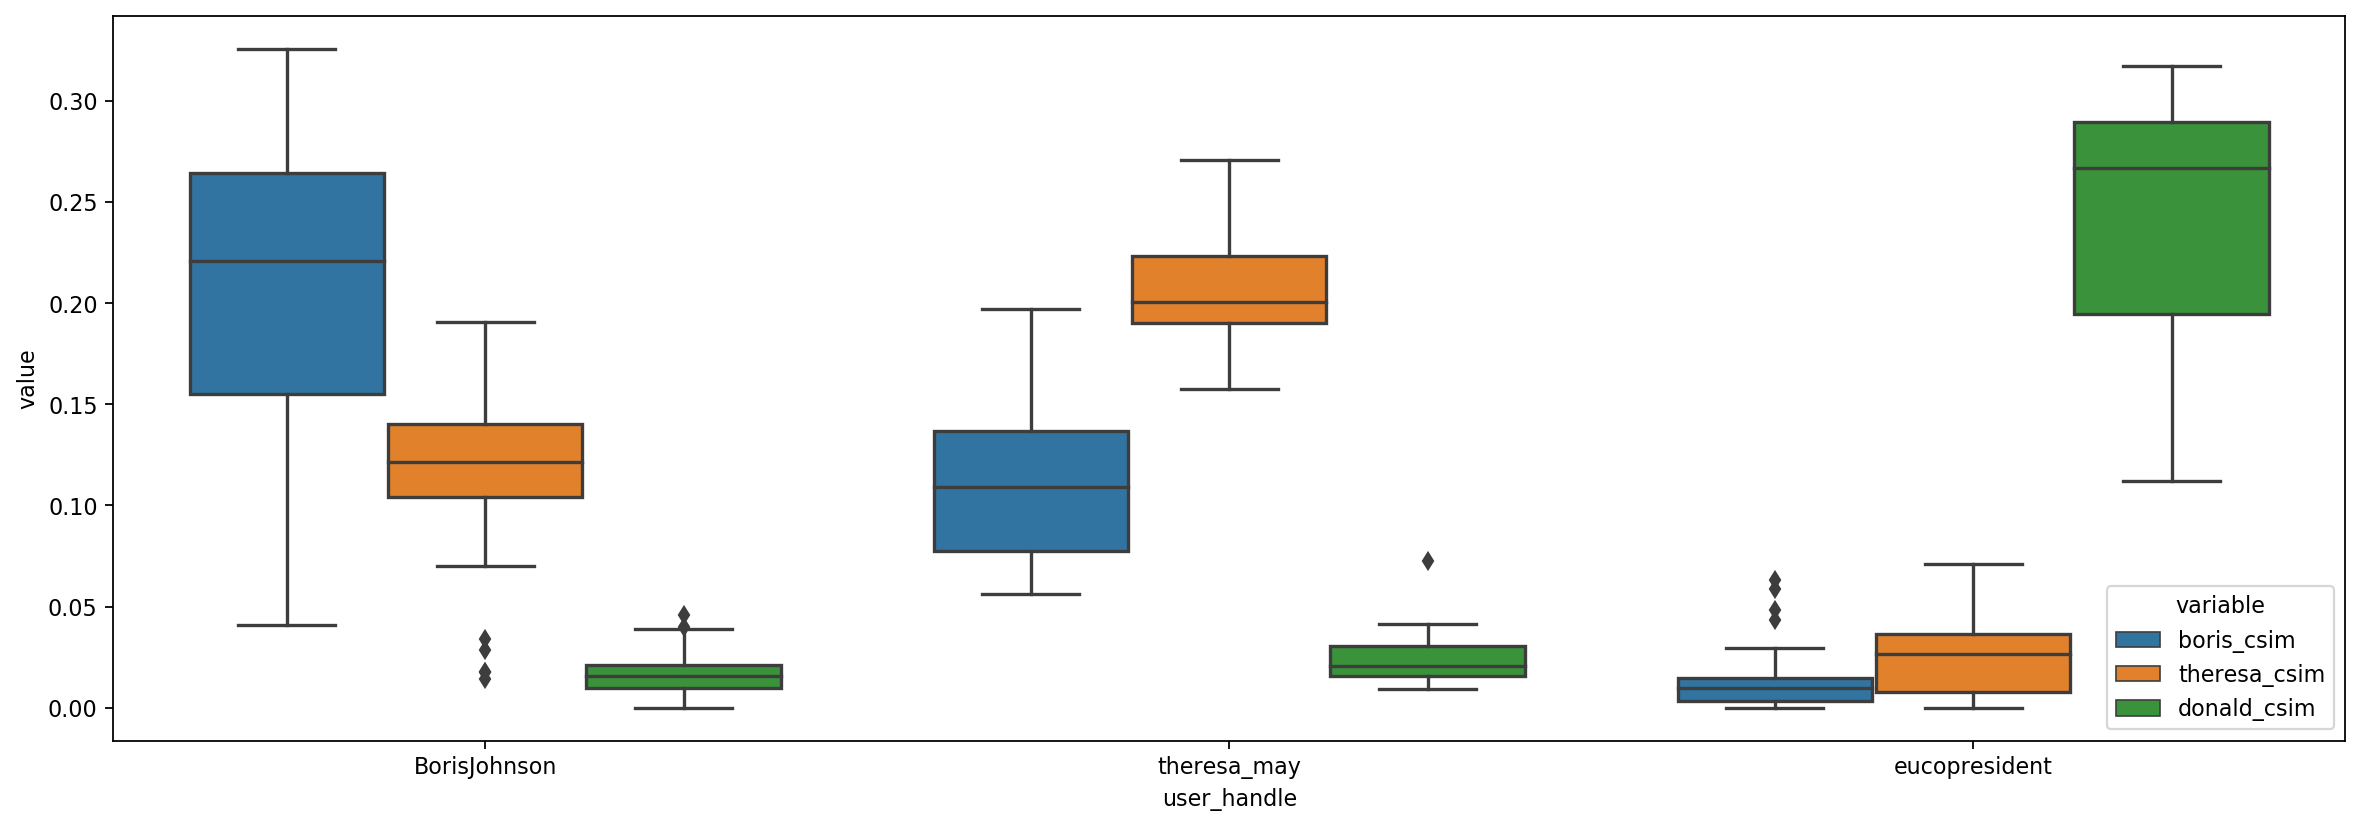

In [162]:
plt.figure(figsize=(18, 6), dpi= 160, facecolor='w', edgecolor='k')
sns.boxplot(x="user_handle", y="value", hue='variable', data=mdf)
plt.show()

In [163]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Exercise 05 (optimizing python efficiency and code structure)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# (1) Write a pre_process() function that takes a string as an input, 
# does the following pre-processing steps, and returns a string with 
# whitespace separated and processed tokens: 
# - Tokenizing (TweetTokenizer)
# - Lowercasing
# - Punctuation Removal
# - Number Removal
# - Stopword Removal
# - Stemming (PorterStemmer)
# - URL Removal

# (2) Use it to recreate the 'processed' variable. I.e., loop through
# each row of the dataframe containing the tweets from Boris, Theresa,
# and Donald, process the respective 'tweet_text,' and save it in the
# 'processed' column.

# (3) Extend the function to take two argument. First, the string of the
# text to be processed, then an argument 'stemming' that is set to True
# by default, but if set to False will skip the step of stemming inside 
# the function.

# (4) Use the time() function from the time package to benchmark how quick
# your function performs with and without stemming.
# Tip: start = time.time() ; end = time.time() ; end-start; Look up
# the documentation of the time.time() function to understand what
# the output means.

# (5) Use the same approach to benchmark how quick the processing of the
# entire tweet texts in df takes when you apply your pre_process() function
# in a classical for-loop vs. list-comprehension.

# (6) Use the multiprocessing package to try to optimize the speed further. 
# Time it and see how it stacks up against for-loops and list-comprehension.
# Tip: pool.map(function, ...)

# (7) Process the JSON file "2019-12-06_16-43-32.json" to extract
# all the tweet texts and compare the time of for-loops, 
# list-comprehension, and parallel processing for a bigger dataset.
# (When processing the JSON file, you can simply focus on 
# tweet['text'] inthe Twitter object and ignore the ideosyncracies 
# of extended_status, retweets and quotes for now. We are interested 
# in processing speed.)
